# Decision Tree

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import pipeline
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import impute
from sklearn import model_selection
from matplotlib import pyplot as plt

# Pre-processing

## Reading csv


In [9]:
dataset = pd.read_csv("./dataset.csv")
dataset.drop(["Unnamed: 0", "track_id", "track_name", "album_name", "artists"], axis=1, inplace=True)

## Show data

In [10]:
print(dataset.shape)
print()
dataset.info()
dataset.head()

(114000, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        114000 non-null  int64  
 1   duration_ms       114000 non-null  int64  
 2   explicit          114000 non-null  bool   
 3   danceability      114000 non-null  float64
 4   energy            114000 non-null  float64
 5   key               114000 non-null  int64  
 6   loudness          114000 non-null  float64
 7   mode              114000 non-null  int64  
 8   speechiness       114000 non-null  float64
 9   acousticness      114000 non-null  float64
 10  instrumentalness  114000 non-null  float64
 11  liveness          114000 non-null  float64
 12  valence           114000 non-null  float64
 13  tempo             114000 non-null  float64
 14  time_signature    114000 non-null  int64  
 15  track_genre       114000 non-null  object 
dtypes: boo

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Clean data

In [11]:
def train_validation_test_split(
    df, target_column, validation_size=0.1, test_size=0.1, random_state=42
):
    df_train, df_test = model_selection.train_test_split(
        df, test_size=test_size, random_state=random_state, stratify=df[target_column]
    )

    df_train, df_validation = model_selection.train_test_split(
        df_train,
        test_size=validation_size / (1 - test_size),
        random_state=random_state,
        stratify=df_train[target_column],
    )
    return df_train, df_validation, df_test


random_state = 42

df_train, df_validation, df_test = train_validation_test_split(
    df=dataset,
    target_column="track_genre",
    validation_size=0.2,
    test_size=0.2,
    random_state=random_state,
)

assert df_train.shape[0] + df_validation.shape[0] + df_test.shape[0] == dataset.shape[0]

## Adding median values to NaN

In [12]:
numeric_columns = df_train.select_dtypes(include=['number']).columns

numeric_imputer = impute.SimpleImputer(strategy="median")

numeric_imputer.fit(df_train[numeric_columns])

df_train[numeric_columns] = numeric_imputer.transform(df_train[numeric_columns])
df_validation[numeric_columns] = numeric_imputer.transform(df_validation[numeric_columns])
df_test[numeric_columns] = numeric_imputer.transform(df_test[numeric_columns])

In [13]:
df_train.dropna(inplace=True, how="any")
df_test.dropna(inplace=True, how="any")
df_validation.dropna(inplace=True, how="any")

## Normalizing data

In [15]:
normalizer = preprocessing.MinMaxScaler()

normalizer.fit(df_train[numeric_columns])

df_train[numeric_columns] = normalizer.transform(df_train[numeric_columns])
df_validation[numeric_columns] = normalizer.transform(df_validation[numeric_columns])
df_test[numeric_columns] = normalizer.transform(df_test[numeric_columns])

## Training

In [16]:
decision_tree = tree.DecisionTreeClassifier(random_state=random_state)

parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["best", "random"],
    "max_depth": np.arange(5, 10000, 50),
    "min_samples_leaf": np.arange(1, 10000, 50),
    "max_features": ["sqrt", "log2"],
    "max_leaf_nodes": np.arange(2, 10000, 50),
}

grid_search = model_selection.RandomizedSearchCV(
    cv=5,
    random_state=random_state,
    n_iter=500,
    n_jobs=-1,
    estimator=decision_tree,
    param_distributions=parameters,
)

grid_search.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': array([   5,   55,  105,  155,  205,  255,  305,  355,  405,  455,  505,
        555,  605,  655,  705,  755,  805,  855,  905,  955, 1005, 1055,
       1105, 1155, 1205, 1255, 1305, 1355, 1405, 1455, 1505, 1555, 1605,
       1655, 1705, 1755, 1805, 1855, 1905, 1...
       6601, 6651, 6701, 6751, 6801, 6851, 6901, 6951, 7001, 7051, 7101,
       7151, 7201, 7251, 7301, 7351, 7401, 7451, 7501, 7551, 7601, 7651,
       7701, 7751, 7801, 7851, 7901, 7951, 8001, 8051, 8101, 8151, 8201,
       8251, 8301, 8351, 8401, 8451, 8501, 8551, 8601, 8651, 8701, 8751,
       8801, 8851, 8901, 8951, 9001, 9051, 9101, 9151, 9201, 9251, 9301,
       9351, 9401, 9451, 9501, 9551, 9601, 9651, 9701, 9751, 9801, 9851,
       9901, 9951]),
                                        'splitter': ['best', 'random']},
                   random_state=42)

In [17]:
print(grid_search.best_params_)
print(grid_search.score(df_validation.iloc[:, :-1], df_validation.iloc[:, -1]))
print(grid_search.score(df_train.iloc[:, :-1], df_train.iloc[:, -1]))


{'splitter': 'best', 'min_samples_leaf': 1, 'max_leaf_nodes': 4952, 'max_features': 'log2', 'max_depth': 305, 'criterion': 'gini'}
0.21907894736842104
0.3953216374269006


In [19]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)


def display_metrics(model, x_test, y_test):
    predicted = model.predict(x_test)
    report = classification_report(y_test, predicted)
    accuracy = accuracy_score(y_test, predicted)
    print(report)
    print(f"accuracy: {accuracy}")

    cm = confusion_matrix(y_test, predicted)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        center=True,
        annot=True,
        yticklabels=model.classes_,
        xticklabels=model.classes_,
    )

                   precision    recall  f1-score   support

         acoustic       0.07      0.10      0.08       200
         afrobeat       0.16      0.18      0.17       200
         alt-rock       0.07      0.10      0.08       200
      alternative       0.18      0.17      0.17       200
          ambient       0.23      0.34      0.28       200
            anime       0.09      0.12      0.10       200
      black-metal       0.44      0.40      0.42       200
        bluegrass       0.20      0.29      0.24       200
            blues       0.08      0.06      0.07       200
           brazil       0.12      0.16      0.13       200
        breakbeat       0.28      0.26      0.27       200
          british       0.05      0.04      0.05       200
         cantopop       0.13      0.17      0.15       200
    chicago-house       0.30      0.32      0.31       200
         children       0.24      0.24      0.24       200
            chill       0.07      0.11      0.09       

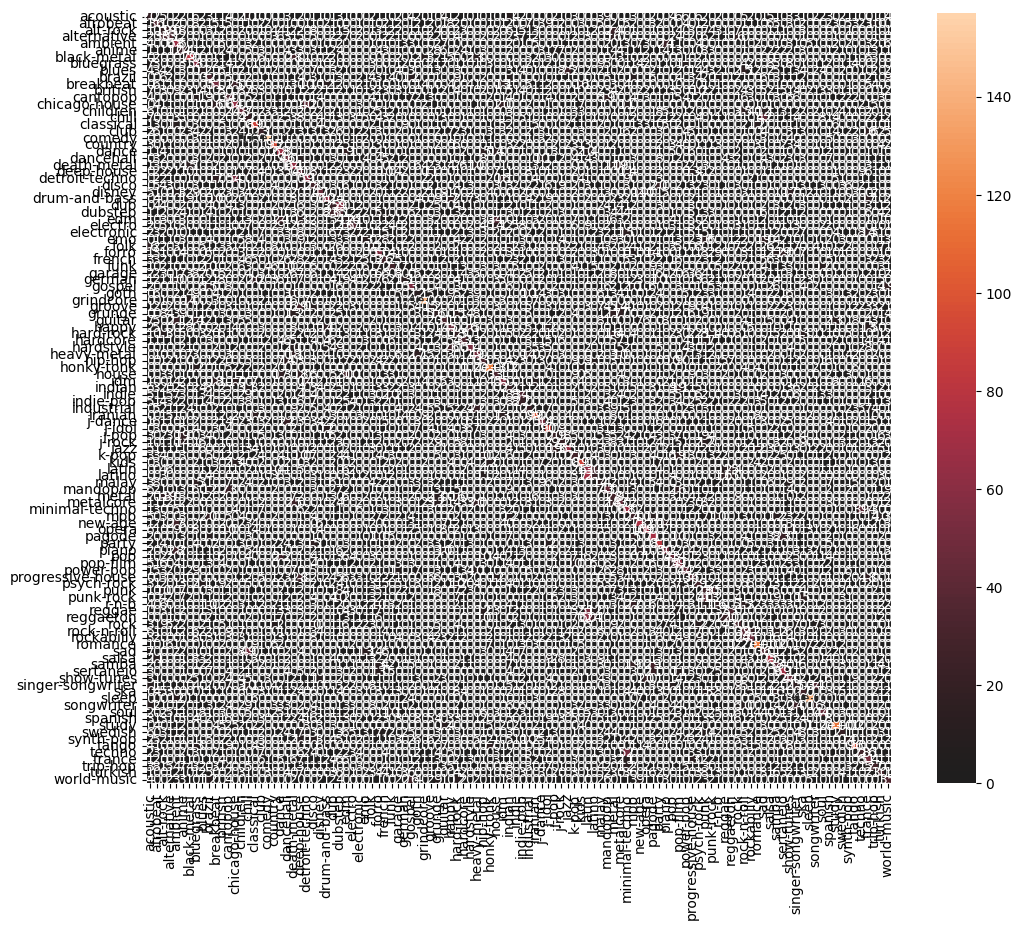

In [20]:
display_metrics(
    grid_search.best_estimator_, df_validation.iloc[:, :-1], df_validation.iloc[:, -1]
)

In [24]:
df_clas_test = df_test["track_genre"]
df_clas_pred = grid_search.best_estimator_.predict(df_test.drop(columns=["track_genre"]))
df_clas_pred_proba = grid_search.best_estimator_.predict_proba(df_test.drop(columns=["track_genre"]))

evaluation = {
    "accuracy": metrics.accuracy_score(df_clas_test, df_clas_pred),
    "precision": metrics.precision_score(
        df_clas_test, df_clas_pred, average="weighted"
    ),
    "recall": metrics.recall_score(df_clas_test, df_clas_pred, average="weighted"),
    "f1": metrics.f1_score(df_clas_test, df_clas_pred, average="weighted"),
    "auc_roc": metrics.roc_auc_score(df_clas_test, df_clas_pred_proba, multi_class="ovr"),
}

print(evaluation)

{'accuracy': 0.21776315789473685, 'precision': 0.22245153954010446, 'recall': 0.21776315789473685, 'f1': 0.2163833463228119, 'auc_roc': 0.7817053068234746}


In [22]:
import pickle

with open("./decision_tree.pkl", "wb") as f:
    pickle.dump(grid_search.best_estimator_, f)

with open("./decision_tree_random_searcher.pkl", "wb") as f:
    pickle.dump(grid_search, f)